# QPEP analysis

This notebook looks at the results from the qpep performance analysis in the opensand testbed.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pickle, os
import re
import matplotlib.colors as mcolors
import matplotlib

plt.rcParams['text.usetex'] = True

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


For each bottleneck bandwidth, I want to plot throughput (i.e. sent bps) against: delays or plr (on two different plots). On the same plot, we have qpep and plain for the 3 different file sizes. Put confidence intervals around the datapoints of one of the file sizes.

I should create a dictionnary with
```bash
bandwidths
|-plr
|--delay
|---filesize [10kbps,100kbps,10mbps]
```


In [3]:
error_percentages = [0,0.01,0.5,1] #that is in packet error
file_sizes = [1e4,1e5,1e7]#in bytes
bandwidths = [7e2,1e4,4e5]#in kbps
delays = [1,10,50,100,250]#Added delay on the satellite link (=RTT/4)

def average_bps(file_path):
    try:
        data = np.loadtxt(file_path)
        # only take values after time is more than 100
        return np.average(data[data[:,0] > 100])
    except: 
        return 0

def get_error(file_path):
    match = re.search(r"_([.\d]*)plr_", file_path)
    if not match: 
        print(f"Error: Error not found in {file_path}")
        return None
    return match.group(1)

def get_delay(file_path):
    match = re.search(r"_(\d+?[\.\d]*?)ms",file_path)
    if not match: 
        print(f"Error: Delay not found in {file_path}")
        return None
    return match.group(1)

def get_bandwidth(file_path):
    match = re.search(r"_(\d+?.\d+?kbps)_",file_path)
    if not match: 
        print(f"Error: Bandwidth not found in {file_path}")
        return None
    return match.group(1)

def filesize_to_number(name):
    match = re.search(r"iperf_(.*?)mb",name)
    if not match:
        print(f"Error: number not found in {name}")
        return None
    return match.group(1)

In [4]:
def plot_throughput(ax, results = {}, bw = '400000kbps',rtt = None, error = None, scenario="",filesize="",colour='red',linestyle='',errorbar=True):
    """Plot the qpep experiments results
    Specify either one error to plot against rtt or one rtt to plot against error
    """
    # Maybe assert that it is a valid rtt
    # assert(results[bw][].keys)
    # Points is an array containing the points to plot
    # every row is a point, which has: an x-value (the error rate), a y-value(the send bps median), a lower error, an upper error
    if rtt is not None:
        points = np.zeros((len(results[bw].keys()),4)) #we have this many different errors
        for j,error in enumerate(results[bw].keys()):
            points[j,:] = float(error)/10 , np.average(results[bw][error][rtt][filesize]), np.min(results[bw][error][rtt][filesize]), np.max(results[bw][error][rtt][filesize])
        
    elif error is not None:
        points = np.zeros((len(results[bw][error].keys()),4)) #we have this many different rtts
        for j,rtt in enumerate(results[bw][error].keys()):
            points[j,:] = 10+float(rtt)*4 , np.average(results[bw][error][rtt][filesize]), np.min(results[bw][error][rtt][filesize]), np.max(results[bw][error][rtt][filesize])
    #reorder the points by x-value
    points = points[points[:,0].argsort()]
    if errorbar:
        ax.errorbar(points[:,0],points[:,1], yerr=[abs(points[:,1]-points[:,2]), abs(points[:,3]-points[:,1])], fmt='none', capsize=3,alpha=0.5,color=colour)
    ax.plot(points[:,0],points[:,1],label=f'{scenario}',marker='x', markerfacecolor="none", markersize = '4',linestyle=linestyle,color=colour)
    return

In [5]:
cca = "Opensand emulation"


def get_results_from_folder_path(folder_path):
    # Get a list of all files in the folder
    file_list = os.listdir(folder_path)
    # Create dictionary to store the average for each error, rtt, and run
    results = {}
    for i,filename in enumerate(file_list):
        bandwidth = get_bandwidth(f'{folder_path}{filename}')
        error = get_error(f'{folder_path}{filename}')
        rtt = get_delay(f'{folder_path}{filename}')
        if bandwidth not in results:
            results[bandwidth] = {}
        if error not in results[bandwidth]:
            results[bandwidth][error] = {}
        if rtt not in results[bandwidth][error]:
            results[bandwidth][error][rtt] = {}
        file = open(f'{folder_path}{filename}','rb')
        data = pickle.load(file)
        for filesize in data.keys():
            #remove throughputs that are zero
            data[filesize]['received_bps'] = [x for x in data[filesize]['received_bps'] if x > 1]
            results[bandwidth][error][rtt][filesize_to_number(filesize)] = np.array(data[filesize]['received_bps'])/1e6
        file.close()
    return results

# sort the dictionary by error key
# results[bw] = dict(sorted(results[bw].items()))

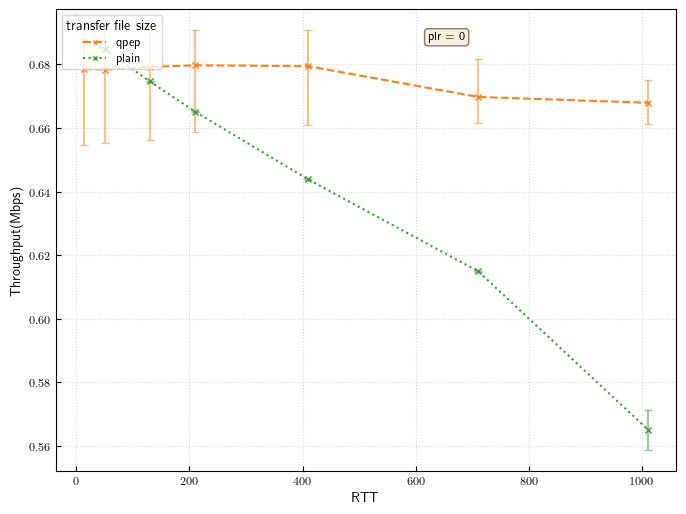

In [6]:
error = '0'
my_colours = list(mcolors.TABLEAU_COLORS.values())
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
fig, ax = plt.subplots(1,1,figsize=(8,6))
bw = '700.0kbps'
results = get_results_from_folder_path("./qpep_results/23.08.23/qpep_iperf/")
plot_throughput(ax,results,bw=bw,error=error, scenario = 'qpep',filesize='0.0',colour = my_colours[1], linestyle='--')
results = get_results_from_folder_path("./qpep_results/23.08.23/plain_iperf/")
plot_throughput(ax,results,bw=bw,error=error, scenario ='plain',filesize='0.0',colour = my_colours[2],linestyle=':')
# bw = '10000.0kbps'
# results = get_results_from_folder_path("./qpep_results/23.08.23/qpep_iperf/")
# plot_throughput(ax,results,bw=bw,error=error, scenario = 'qpep',filesize='0.0',colour = my_colours[3],  linestyle='--')
# results = get_results_from_folder_path("./qpep_results/23.08.23/plain_iperf/")
# plot_throughput(ax,results,bw=bw,error=error, scenario ='plain',filesize='0.0',colour = my_colours[4],linestyle=':')
# bw = '400000.0kbps'
# results = get_results_from_folder_path("./qpep_results/23.08.23/qpep_iperf/")
# plot_throughput(ax,results,bw=bw,error=error, scenario = 'qpep',filesize='0.0',colour = my_colours[5],  linestyle='--')
# results = get_results_from_folder_path("./qpep_results/23.08.23/plain_iperf/")
# plot_throughput(ax,results,bw=bw,error=error, scenario ='plain',filesize='0.0',colour = my_colours[6],linestyle=':')
ax.text(0.6, 0.95, f"plr = {error}", transform=ax.transAxes, fontsize="small", verticalalignment='top', bbox=props)
plt.tick_params(axis='both', direction='in',labelsize="small", grid_alpha=0.5, grid_linestyle=':')
ax.legend(title=f"transfer file size",loc='upper left',fontsize="small", markerscale=0.6)
ax.set_xlabel("RTT")
ax.set_ylabel("Throughput(Mbps)")
ax.grid()
plt.show()

In [9]:
save_figure = True
filename = "qpep_throughput_vs_rtt_27_08_23"
if save_figure:
    plt.rcParams.update(plt.rcParamsDefault)
    matplotlib.use("pgf")
    matplotlib.rcParams.update(
        {
            # Adjust to your LaTex-Engine
            "pgf.texsystem": "pdflatex",
            "font.family": "serif",
            "text.usetex": True,
            "pgf.rcfonts": False,
            "axes.unicode_minus": False,
        }
    )
    plt.close('all')
else:
    plt.rcParams.update(plt.rcParamsDefault)
    matplotlib.use("GTK3Agg")

error_percentages = ['0','0.01','1']
#my_colours = list(mcolors.TABLEAU_COLORS.values())
my_colours = ['#0f5b12','#35b539','#009877','#5e03fc','#c26df7','#ca03fc']
props = dict(boxstyle='round', facecolor='white', alpha=0.7)
fig, ax = plt.subplots(3,1,figsize=(5,5),sharex=True)
bandwidths = ['400000.0kbps','10000.0kbps','700.0kbps']
for j,bw in enumerate(bandwidths):
    results = get_results_from_folder_path("./qpep_results/23.08.23/qpep_iperf/")
    for i,error in enumerate(error_percentages):
        plot_throughput(ax[j],results,bw=bw,error=error, scenario = f'qpep, plr={error}%',filesize='0.0',colour =my_colours[i], linestyle='--')
    results = get_results_from_folder_path("./qpep_results/23.08.23/plain_iperf/")
    for i,error in enumerate(error_percentages):
        plot_throughput(ax[j],results,bw=bw,error=error, scenario =f'plain, plr={error}%',filesize='0.0',colour = my_colours[i+3],linestyle=':')
ax[0].text(0.25, 0.95, f"bottleneck bandwidth = 400Mbps", transform=ax[0].transAxes, fontsize="small", verticalalignment='top', bbox=props)
ax[1].text(0.18, 0.26, f"bottleneck bandwidth = 10Mbps", transform=ax[1].transAxes, fontsize="small", verticalalignment='top', bbox=props)
ax[2].text(0.06, 0.12, f"bottleneck bandwidth = 0.7Mbps", transform=ax[2].transAxes, fontsize="small", verticalalignment='top', bbox=props)
for i in range(3):
    ax[i].set_ylabel("Throughput(Mbps)")
    ax[i].tick_params(axis='both', direction='in',labelsize="small", grid_alpha=0.5, grid_linestyle=':')
    ax[i].grid()
ax[0].legend(title=f"Scenario",loc='upper right',fontsize="small", markerscale=0.6)
ax[2].set_xlabel("RTT of satellite link(ms)")
plt.tight_layout()
fig.subplots_adjust(hspace=0.06)
if save_figure:
    plt.savefig(f"../Thesis/plots/qpep/{filename}.pgf")
else:
    plt.show()

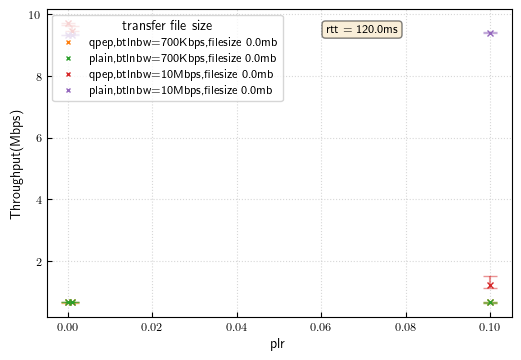

In [13]:
delay = '30'
my_colours = list(mcolors.TABLEAU_COLORS.values())
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
fig, ax = plt.subplots(1,1,figsize=(6,4))
bw = '700.0kbps'
results = get_results_from_folder_path("./qpep_results/23.08.23/qpep_iperf/")
plot_throughput(ax,results,bw=bw,rtt=delay, scenario = 'qpep,btlnbw=700Kbps',filesize='0.0',colour = my_colours[1])
results = get_results_from_folder_path("./qpep_results/23.08.23/plain_iperf/")
plot_throughput(ax,results,bw=bw,rtt = delay, scenario ='plain,btlnbw=700Kbps',filesize='0.0',colour = my_colours[2])
bw = '10000.0kbps'
results = get_results_from_folder_path("./qpep_results/23.08.23/qpep_iperf/")
plot_throughput(ax,results,bw=bw,rtt=delay, scenario = 'qpep,btlnbw=10Mbps',filesize='0.0',colour = my_colours[3])
results = get_results_from_folder_path("./qpep_results/23.08.23/plain_iperf/")
plot_throughput(ax,results,bw=bw,rtt = delay, scenario ='plain,btlnbw=10Mbps',filesize='0.0',colour = my_colours[4])
ax.text(0.6, 0.95, f"rtt = {float(delay)*4}ms", transform=ax.transAxes, fontsize="small", verticalalignment='top', bbox=props)
plt.tick_params(axis='both', direction='in',labelsize="small", grid_alpha=0.5, grid_linestyle=':')
ax.legend(title=f"transfer file size",loc='upper left',fontsize="small", markerscale=0.6)
ax.set_xlabel("plr")
ax.set_ylabel("Throughput(Mbps)")
ax.grid()
plt.show()

In [34]:
results = get_results_from_folder_path("./qpep_results/23.08.23/qpep_iperf/")
print(results)

{'700.0kbps': {'0.01': {'100': {'0.0': array([0.676164, 0.680327, 0.690911])}, '10': {'0.0': array([0.689929, 0.690125, 0.654938])}, '250': {'0.0': array([0.674102, 0.690812, 0.690812])}, '175': {'0.0': array([0.681014, 0.680327, 0.690812])}, '30': {'0.0': array([0.690518, 0.690812, 0.65611 ])}, '1': {'0.0': array([0.690714, 0.689929, 0.654642])}, '50': {'0.0': array([0.689634, 0.690812, 0.690812])}}, '1': {'50': {'0.0': array([0.610333, 0.657814, 0.649753])}, '100': {'0.0': array([0.437613, 0.453803, 0.476738])}, '250': {'0.0': array([0.229734, 0.185758, 0.218204])}, '175': {'0.0': array([0.360413, 0.243135, 0.281475])}, '30': {'0.0': array([0.677509, 0.672659, 0.677803])}, '1': {'0.0': array([0.680425, 0.679345, 0.679247])}, '10': {'0.0': array([0.679345, 0.679149, 0.678952])}}, '0': {'1': {'0.0': array([0.690812, 0.690027, 0.65481 ])}, '50': {'0.0': array([0.689733, 0.690812, 0.65864 ])}, '10': {'0.0': array([0.689929, 0.690027, 0.655141])}, '100': {'0.0': array([0.686649, 0.690714,

In [36]:
plt.close('all')

{'700.0kbps': {'1': {'50': {'0.0': array([0.67849])}, '100': {'0.0': array([0.680326])}, '250': {'0.0': array([0.682163])}, '1': {'0.0': array([0.682261])}, '10': {'0.0': array([0.680523])}}, '0': {'1': {'0.0': array([0.690812])}, '50': {'0.0': array([0.690714])}, '10': {'0.0': array([0.691107])}, '100': {'0.0': array([0.690812])}, '250': {'0.0': array([0.691009])}}}, '400000.0kbps': {'1': {'250': {'0.0': array([22.3657])}, '100': {'0.0': array([22.8445])}, '10': {'0.0': array([22.0561])}, '50': {'0.0': array([18.6784])}, '1': {'0.0': array([22.6466])}}, '0': {'100': {'0.0': array([36.6398])}, '50': {'0.0': array([32.4265])}, '250': {'0.0': array([36.7544])}, '10': {'0.0': array([37.5312])}, '1': {'0.0': array([39.1649])}}}, '10000.0kbps': {'1': {'50': {'0.0': array([9.55982])}, '100': {'0.0': array([9.56621])}, '250': {'0.0': array([9.56874])}, '10': {'0.0': array([9.55652])}, '1': {'0.0': array([9.55991])}}, '0': {'250': {'0.0': array([9.62913])}, '1': {'0.0': array([9.62864])}, '50'

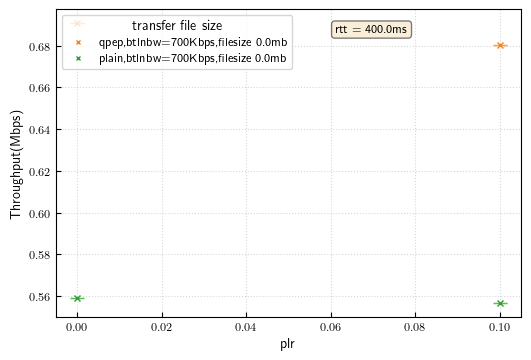

In [148]:
def get_delay(file_path):
    match = re.search(r"_(\d+?[\.\d]*?)ms",file_path)
    if not match: 
        print(f"Error: Delay not found in {file_path}")
        return None
    return match.group(1)

delay = '100'
my_colours = list(mcolors.TABLEAU_COLORS.values())
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
fig, ax = plt.subplots(1,1,figsize=(6,4))
bw = '700.0kbps'
filesize = '0.0'
results = get_results_from_folder_path("./qpep_results/21.08.23/qpep_iperf_time/")
print(results)
plot_throughput(ax,results,bw=bw,rtt=delay, scenario = 'qpep,btlnbw=700Kbps',filesize=filesize,colour = my_colours[1])
results = get_results_from_folder_path("./qpep_results/21.08.23/plain_iperf_time/")
plot_throughput(ax,results,bw=bw,rtt = delay, scenario ='plain,btlnbw=700Kbps',filesize=filesize,colour = my_colours[2])
ax.text(0.6, 0.95, f"rtt = {float(delay)*4}ms", transform=ax.transAxes, fontsize="small", verticalalignment='top', bbox=props)
plt.tick_params(axis='both', direction='in',labelsize="small", grid_alpha=0.5, grid_linestyle=':')
ax.legend(title=f"transfer file size",loc='upper left',fontsize="small", markerscale=0.6)
ax.set_xlabel("plr")
ax.set_ylabel("Throughput(Mbps)")
ax.grid()
plt.show()

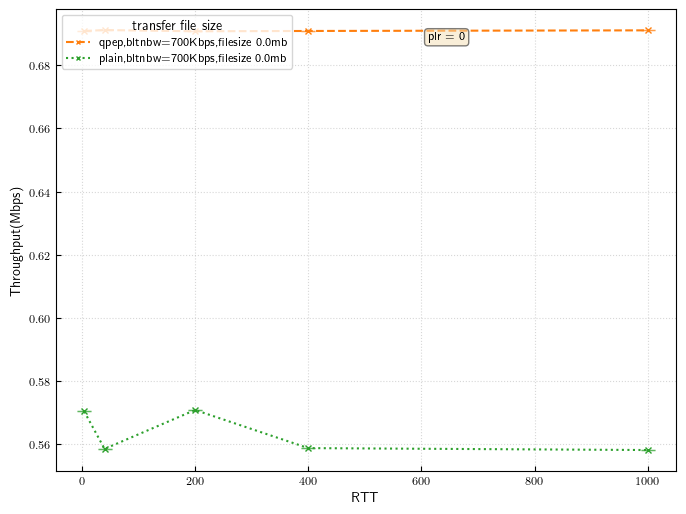

In [150]:
error = '0'
my_colours = list(mcolors.TABLEAU_COLORS.values())
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
fig, ax = plt.subplots(1,1,figsize=(8,6))
bw = '700.0kbps'
filesize ='0.0'
results = get_results_from_folder_path("./qpep_results/21.08.23/qpep_iperf_time/")
plot_throughput(ax,results,bw=bw,error=error, scenario = 'qpep,bltnbw=700Kbps',filesize=filesize,colour = my_colours[1], linestyle='--')
results = get_results_from_folder_path("./qpep_results/21.08.23/plain_iperf_time/")
plot_throughput(ax,results,bw=bw,error=error, scenario ='plain,bltnbw=700Kbps',filesize=filesize,colour = my_colours[2],linestyle=':')
# bw = '10000.0kbps'
# results = get_results_from_folder_path("./qpep_results/18.08.23/qpep_iperf/")
# plot_throughput(ax,results,bw=bw,error=error, scenario = 'qpep,bltnbw=10Mbps',filesize='10.0',colour = my_colours[3])
# results = get_results_from_folder_path("./qpep_results/18.08.23/plain_iperf/")
# plot_throughput(ax,results,bw=bw,error=error, scenario ='plain,bltnbw=10Mbps',filesize='10.0',colour = my_colours[4])
# bw = '400000.0kbps'
# results = get_results_from_folder_path("./qpep_results/18.08.23/qpep_iperf/")
# plot_throughput(ax,results,bw=bw,error=error, scenario = 'qpep,bltnbw=400Mbps',filesize='10.0',colour = my_colours[5])
# results = get_results_from_folder_path("./qpep_results/18.08.23/plain_iperf/")
# plot_throughput(ax,results,bw=bw,error=error, scenario ='plain,bltnbw=400Mbps',filesize='10.0',colour = my_colours[6])
ax.text(0.6, 0.95, f"plr = {error}", transform=ax.transAxes, fontsize="small", verticalalignment='top', bbox=props)
plt.tick_params(axis='both', direction='in',labelsize="small", grid_alpha=0.5, grid_linestyle=':')
ax.legend(title=f"transfer file size",loc='upper left',fontsize="small", markerscale=0.6)
ax.set_xlabel("RTT")
ax.set_ylabel("Throughput(Mbps)")
ax.grid()
plt.show()